In [81]:
import os
import matplotlib.pyplot as plt

import numpy as np

import keras
from keras.models import Sequential

import scipy

import mne

DATA_PATH = "/home/mahabib/data/4244171"
TARGET_HZ = 100
SEG_LEN = 1 * TARGET_HZ

# Downsampe and load EDF files

In [4]:
def down_sample(recording, src_hz, target_hz):
    down_factor = src_hz // target_hz
    target_samples = len(recording) // down_factor
    recording = scipy.signal.resample(recording, target_samples)
    return recording


def load_eeg_channel(edf_file, ch_name="FP1", fs_target=100, log=print):
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=False)
        ch_idx = -1        
        for cname in raw.info.get('ch_names'):
            ch_idx += 1
            if cname.upper().find(ch_name.upper()) > -1:
                ch_name = cname
                break
        raw.pick_channels([ch_name])
        hz = raw.info.get('sfreq')
        hz = int(hz)        
        recording = raw.get_data().flatten()

    except:
        log(f"Error reading {edf_file}, caused by - {traceback.format_exc()}")
        return
        
    if hz != fs_target: # Down sample
        recording = down_sample(recording, hz, fs_target)
    log(f"channel_names:{raw.info.get('ch_names')}, src-Hz:{hz}, target-Hz:{fs_target}")
    return recording


# EDF file reading
- multi-channel data in a single EDF file
- file contains meta information which are common to all the channels in the file
- channel has names
- we can look into any particular channel, by name/index
- seek for meta information for any particular channel

In [82]:
# load EDF file
# 
raw = mne.io.read_raw_edf(f"{DATA_PATH}/H S1 EC.edf", preload=False)
print(raw)

# get info general
# 
print("\nAll Info ----> \n", raw.info)
print("\nchannel names:", raw.info.get('ch_names'))

# get info - channel specific
# 
print("\nLooking into the first channel...")
ch_idx = 0  # Fp1-LE
ch_name = raw.info.get('ch_names')[ch_idx]
raw.pick(ch_name)  # Jump/pick into a specific channel

print("\nFp1-LE channel Info ----> \n", raw.info)
print("sample frequency:", raw.info['sfreq'])
print("\nchannel names:", raw.info.get('ch_names'))
hz = int(raw.info['sfreq'])

# get the signal
# 
signal = raw.get_data()
print(signal.shape)

signal = signal.flatten()
print(signal.shape)

Extracting EDF parameters from /home/mahabib/data/4244171/H S1 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<RawEDF | H S1 EC.edf, 22 x 76800 (300.0 s), ~26 kB, data not loaded>

All Info ----> 
 <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-LE, EEG F3-LE, EEG C3-LE, EEG P3-LE, EEG O1-LE, EEG ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 80.0 Hz
 meas_date: 2011-08-16 17:48:54 UTC
 nchan: 22
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>

channel names: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']

Looking into the first channel...

Fp1-LE channel Info ----> 
 <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-LE
 chs: 1 EEG
 custom_ref_appli

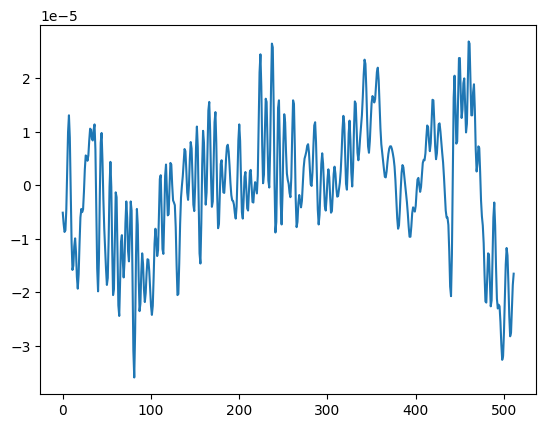

(512,)


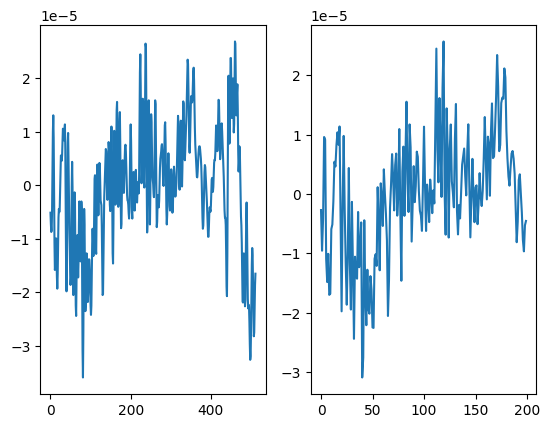

(512,)


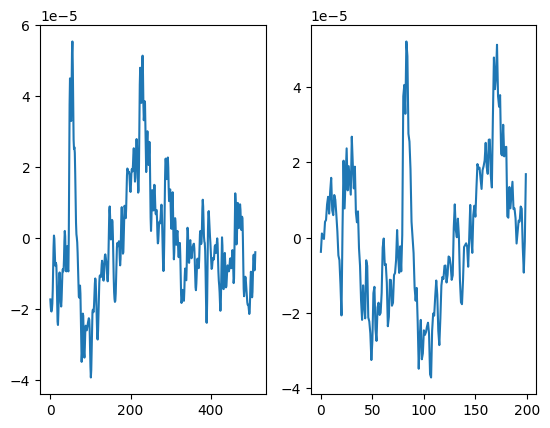

(512,)


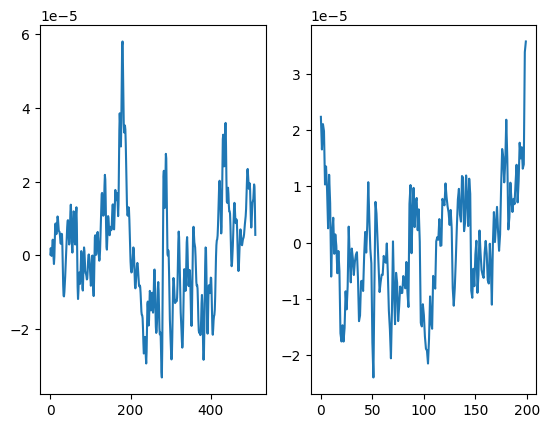

(512,)


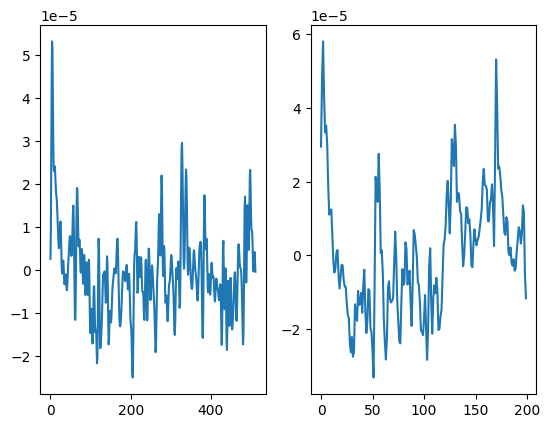

(512,)


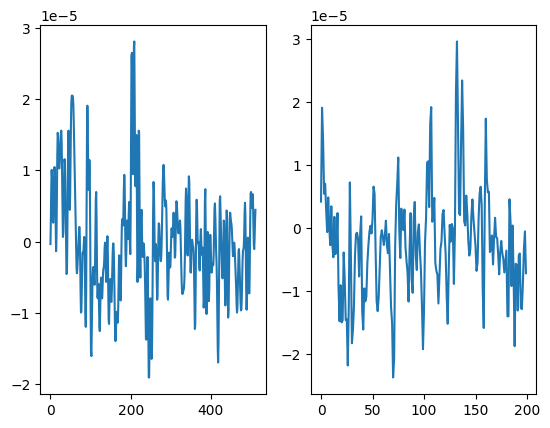

In [83]:
n_samp = hz * 2
plt.plot(range(n_samp), signal[:n_samp]),
plt.show()

signal_100hz = down_sample(signal, hz, 100)
n_samp_100hz = 100 * 2

for i in range(5):
    segment = signal[i*n_samp : (i+1)*n_samp]
    plt.subplot(121)    
    plt.plot(range(n_samp), segment)
    print(segment.shape)

    # downsample signal
    segment = signal_100hz[i*n_samp_100hz: (i+1)*n_samp_100hz]
    plt.subplot(122)    
    plt.plot(range(100 * 2), segment)
    
    plt.show()

# Data Generator
- https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
- Load entire dataset needs large memory, so we need to create batch of data
- X, y = np.load('some_training_set_with_labels.npy')  # Load entire dataset, this needs to be changed

In [84]:
def do_segmentation():
    segments = []
    labels = []
    subject_wise_segments = {}

    for f in os.listdir(DATA_PATH):
        if not f.endswith("EC.edf"):
            continue
        eeg_record = load_eeg_channel(os.path.join(DATA_PATH, f), ch_name="Fp1", fs_target=100)
        label = 1 if f.startswith("MDD") else 0
        print(f, eeg_record.shape)

        start = 0
        while start + SEG_LEN <= len(eeg_record):
            seg = eeg_record[start:start+SEG_LEN]
            
            # append to lists
            # 
            segments.append(seg)
            labels.append(label)
            if subject_wise_segments.get(f) is None:
                subject_wise_segments[f] = []
            subject_wise_segments[f].append(len(segments)-1)  # record sample index
            
            start += SEG_LEN
        print(f"*[{f}] n_segments:{len(subject_wise_segments[f])}")
        
        # break
        
    return segments, labels, subject_wise_segments

segments, labels, subject_wise_segments = do_segmentation()

print(f"n_subjects:{len(subject_wise_segments.keys())}, segments:{len(segments)}, labels:{len(labels)}")

Extracting EDF parameters from /home/mahabib/data/4244171/H S21 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
channel_names:['EEG Fp1-LE'], src-Hz:256, target-Hz:100
H S21 EC.edf (38528,)
*[H S21 EC.edf] n_segments:385
Extracting EDF parameters from /home/mahabib/data/4244171/MDD S2  EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
channel_names:['EEG Fp1-LE'], src-Hz:256, target-Hz:100
MDD S2  EC.edf (38016,)
*[MDD S2  EC.edf] n_segments:380
Extracting EDF parameters from /home/mahabib/data/4244171/MDD S18 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
channel_names:['EEG Fp1-LE'], src-Hz:256, target-Hz:100
MDD S18

In [85]:
# global index of samples
# 
indexes = [i for i in range(len(segments))]
# print(indexes)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(indexes, labels, test_size=0.2, random_state=0)
print(f"train: {len(X_train)}, test: {len(X_test)}")

# print(X_test)
print("traning class-0:", len([i for i in range(len(X_train)) if labels[i]==0]))
print("traning class-1:", len([i for i in range(len(X_train)) if labels[i]==1]))

train: 17784, test: 4446
traning class-0: 8527
traning class-1: 9257


In [87]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=1*100, n_channels=1,
                 n_classes=10, shuffle=True, segments=[]):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.segments = segments
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # X[i,] = np.load('data/' + ID + '.npy')
            X[i, ] = np.expand_dims(self.segments[ID], axis=1)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [65]:
# Parameters
params = {'dim': SEG_LEN,
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = {
    "train": X_train,
    "validation": X_test,
}
labels = labels

# Generators
training_generator = DataGenerator(partition['train'], labels, segments=segments, **params)
validation_generator = DataGenerator(partition['validation'], labels, segments=segments, **params)

batch sample: (32, 100, 1)


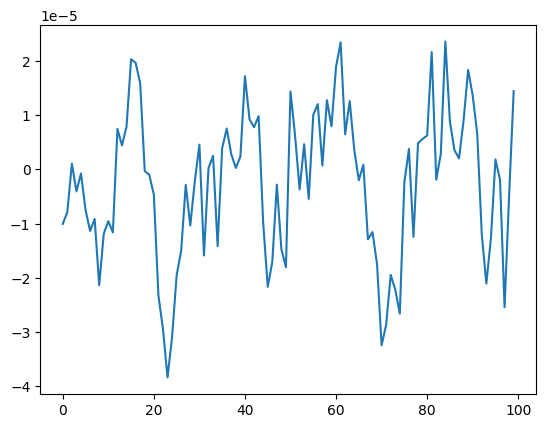

In [88]:
batch_sample = training_generator[0]
print("batch sample:", batch_sample[0].shape)

plt.plot(range(SEG_LEN), batch_sample[0][0, :, 0])
plt.show()

In [89]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense

# CNN models
# 
def cnn_baseline_model():
    # create model
    model = Sequential()
    
    # Feature extracting layers
    model.add(Conv1D(32, (5,), input_shape=(SEG_LEN, 1), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2,)))

    # intermediate feature outputs, flattens to form vectors, required for MLPs
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    # Decision layers- MLPs
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




# Design model
model = cnn_baseline_model()

# Train model on dataset
model.fit(training_generator,
            validation_data=validation_generator,
            use_multiprocessing=False, epochs=10,
            workers=1)

Epoch 1/10


2024-05-22 14:57:54.953099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


555/555 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.5070
Epoch 2/10


2024-05-22 14:57:56.561358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


555/555 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5078 - val_loss: 0.6932 - val_accuracy: 0.5050
Epoch 3/10
555/555 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 4/10
555/555 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5078 - val_loss: 0.6930 - val_accuracy: 0.5079
Epoch 5/10
555/555 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5068
Epoch 6/10
555/555 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 7/10
555/555 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 8/10
555/555 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6931 - val_accuracy: 0.5057
Epoch 9/10
555/55

In [90]:
print(subject_wise_segments.keys())

dict_keys(['H S21 EC.edf', 'MDD S2  EC.edf', 'MDD S18 EC.edf', 'H S6 EC.edf', 'MDD S1 EC.edf', 'MDD S10 EC.edf', 'MDD S25 EC.edf', 'H S9 EC.edf', 'MDD S9 EC.edf', 'MDD S21 EC.edf', 'MDD S19 EC.edf', 'H S30 EC.edf', 'H S4 EC.edf', 'MDD S26 EC.edf', 'H S26 EC.edf', 'MDD S31 EC.edf', 'H S25 EC.edf', 'MDD S27 EC.edf', 'H S24 EC.edf', 'MDD S13 EC.edf', 'H S13 EC.edf', 'H S22 EC.edf', 'MDD S20 EC.edf', 'MDD S28 EC.edf', 'MDD S15 EC.edf', 'H S23 EC.edf', 'MDD S32 EC.edf', 'MDD S17 EC.edf', 'H S11 EC.edf', 'MDD S24  EC.edf', 'H S2 EC.edf', 'H S14 EC.edf', 'MDD S22 EC.edf', 'MDD S30 EC.edf', 'H S8 EC.edf', 'MDD S6 EC.edf', 'H S15 EC.edf', 'H S3 EC.edf', 'MDD S5 EC.edf', 'H S28 EC.edf', 'H S7 EC.edf', 'H S16 EC.edf', 'H S1 EC.edf', 'MDD S7  EC.edf', 'H S29 EC.edf', 'MDD S11  EC.edf', 'MDD S3 EC.edf', 'MDD S34 EC.edf', 'H S10 EC.edf', 'MDD S14 EC.edf', 'H S17 EC.edf', 'H S19 EC.edf', 'H S20 EC.edf', 'H S5 EC.edf', 'MDD S23 EC.edf', 'H S27 EC.edf', 'MDD S29 EC.edf', 'MDD S33 EC.edf'])


In [92]:
print(subject_wise_segments['MDD S29 EC.edf'])

[21465, 21466, 21467, 21468, 21469, 21470, 21471, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21479, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21488, 21489, 21490, 21491, 21492, 21493, 21494, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21531, 21532, 21533, 21534, 21535, 21536, 21537, 21538, 21539, 21540, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21574, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21603, 21604, 21605, 21606, 21607